# Introduction: Random Forest in Python

In this notebook, we will implement a random forest in Python. With machine learning in Python, it's very easy to build a complex model without having any idea how it works. Therefore, we'll start with a single decision tree and a simple problem, and then work our way to a random forest and a real-world problem. 

Once we understand how a single decision tree thinks, we can transfer this knowledge to an entire forest of trees.

In [95]:
import numpy as np
import pandas as pd

# Set random seed to ensure reproducible runs
RSEED = 100

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import export_graphviz
from graphviz import Source


In [97]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=RSEED)


# Real Dataset

[Available Here](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training. 

The problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem.

## Data Cleaning 

We'll read the data in and do a little cleaning. 

#syntax for getting sample from file
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html

In [98]:
#file 2015.csv has 441457 rows we take only 100000 rows
df = pd.read_csv('2015.csv').sample(100000,replace=True, random_state = RSEED)
df.head()


_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
38408      8.0     4.0  b'04292015'  b'04'  b'29'  b'2015'    1100.0   
56088      9.0    11.0  b'11302015'  b'11'  b'30'  b'2015'    1200.0   
210755    28.0     5.0  b'06022015'  b'06'  b'02'  b'2015'    1100.0   
77655     12.0     6.0  b'06122015'  b'06'  b'12'  b'2015'    1100.0   
65615     10.0     4.0  b'04092015'  b'04'  b'09'  b'2015'    1100.0   

               SEQNO          _PSU  CTELENUM  ...  _PAREC1  _PASTAE1  \
38408   2.015001e+09  2.015001e+09       1.0  ...      4.0       2.0   
56088   2.015005e+09  2.015005e+09       1.0  ...      9.0       9.0   
210755  2.015001e+09  2.015001e+09       1.0  ...      4.0       2.0   
77655   2.015007e+09  2.015007e+09       NaN  ...      4.0       2.0   
65615   2.015003e+09  2.015003e+09       NaN  ...      2.0       2.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
38408        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
56088        3.0       3.0       4.0       9.0       9.0       NaN       NaN   
210755       3.0       3.0       4.0       1.0       1.0       1.0       1.0   
77655        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
65615        3.0       3.0       4.0       1.0       1.0       1.0       2.0   

        _AIDTST3  
38408        2.0  
56088        NaN  
210755       2.0  
77655        2.0  
65615        2.0  

[5 rows x 330 columns]

In [99]:
df.dtypes

_STATE      float64
FMONTH      float64
IDATE        object
IMONTH       object
IDAY         object
             ...   
_RFSEAT2    float64
_RFSEAT3    float64
_FLSHOT6    float64
_PNEUMO2    float64
_AIDTST3    float64
Length: 330, dtype: object

# syntax to select dataframe coulmns  with only numbers

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html



In [100]:
#get columns with number only
df = df.select_dtypes('number')
df.info()
#seven columns are removed as their data types is not number

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 38408 to 29090
Columns: 323 entries, _STATE to _AIDTST3
dtypes: float64(323)
memory usage: 247.2 MB


### Label Distribution

In [101]:
# _RFHLTH IS FOR Adults with good health we will use this column as target or label
#column _RFHLTH is for good health with values  1=good health, 2=fair health,9=dont know

dRFHLTH=df['_RFHLTH']
print(df['_RFHLTH'])

38408     1.0
56088     1.0
210755    2.0
77655     1.0
65615     1.0
         ... 
96079     1.0
115475    1.0
33506     1.0
175316    1.0
29090     1.0
Name: _RFHLTH, Length: 100000, dtype: float64


In [102]:
# we will make _RFHLTH column as LABEL
#column _RFHLTH is for good health with values  1=good health, 2=fair health,9=dont know

# replace 2 with 0  in column _RFHLTH
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})

# select rows with 0 and 1 in column _RFHLTH
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()

#rename _RFHLTH  Column as Label
df = df.rename(columns = {'_RFHLTH': 'label'})

#count Values in label column
df['label'].value_counts()

1.0    81647
0.0    18119
Name: label, dtype: int64

The label imbalanced means that accuracy is not the best metric. 

We won't do any data exploration in this notebook, but in general, exploring the data is a best practice. This can help you for feature engineering (which we also won't do here) or by identifying and correcting anomalies / mistakes in the data.

Below, we drop a number of columns that we should not use for modeling (they are different versions of the labels).

In [103]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99766 entries, 38408 to 29090
Columns: 314 entries, _STATE to _AIDTST3
dtypes: float64(314)
memory usage: 239.8 MB


In [104]:
#drop columns with nan values
df=df.dropna(axis='columns')
df.shape

(99766, 86)

## Split Data into Training and Testing Set

To assess our predictions, we'll need to use a training and a testing set. The model learns from the training data and then makes predictions on the testing data. Since we have the correct answers for the testing data, we can tell how well the model is able to generalize to new data. It's important to only use the testing set once, because this is meant to be an estimate of how well the model will perform on new data. 

We'll save 30% of the examples for testing. 

In [105]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [106]:
train.shape

(69836, 85)

In [107]:
test.shape

(29930, 85)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [108]:
features = list(train.columns)


In [109]:
#check nan in train
check_nan_in_df = train.isnull().values.any()
print (check_nan_in_df)


False


In [110]:
#check nan in test
check_nan_in_df = test.isnull().values.any()
print (check_nan_in_df)


False


In [111]:
print(type(train_labels))

<class 'numpy.ndarray'>


In [112]:
#train_labels is array .check nan in array
array_has_nan = np.isnan(train_labels).any()
print(array_has_nan)



False


In [113]:
#test_labels is array. check nan in array
array_has_nan = np.isnan(test_labels).any()
print(array_has_nan)



False


## Decision Tree on Real Data

First, we'll train the decision tree on the data. Let's leave the depth unlimited and see if we get overfitting! 

In [114]:
# Train tree
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 14789 nodes with maximum depth 41.


## Assess Decision Tree Performance

Given the number of nodes in our decision tree and the maximum depth, we expect it has overfit to the training data. This means it will do much better on the training data than on the testing data.

In [115]:
# Make probability predictions
#tree.predict_proba uses tree to predict classes for given input .output is two columns olumn0=0 class column1 =1class
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [116]:
#tree.predict_proba returns ndarray with two columns.
#first column is probability of class=0.second column is probability of class=1
print(train_probs)

[1. 1. 1. ... 0. 1. 1.]


In [117]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
#roc_auc_score calculates area under ROC curve from prediction scores.(train labels and probabilities of labels)
#under the hood roc_auc_score calculates ROC for different thresholds and calculates AUC from ROC

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.7446669223794531


In [118]:
#syntax to create list length=test_labels filled with 1's.here _ is variable in for loop
d=[1 for _ in range(len(test_labels))]
print(d)
print(type(d))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [119]:
# baseline ROC is the line in ROC curve where TPR and Fpr are equal for all thresholds of probabilities
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

## Evaluate the Decision Tree

We'll write a short function that calculates a number of metrics for the baseline (guessing the most common label in the training data), the testing predictions, and the training predictions. The function also plots the ROC curve where a better model is to the left and towards the top. 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [120]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


In [121]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 24385, 0.0: 5545})
Counter({1.0: 24385, 0.0: 5545})


Recall Baseline: 1.0 Test: 0.9 Train: 1.0
Precision Baseline: 0.82 Test: 0.91 Train: 1.0
Roc Baseline: 0.5 Test: 0.74 Train: 1.0


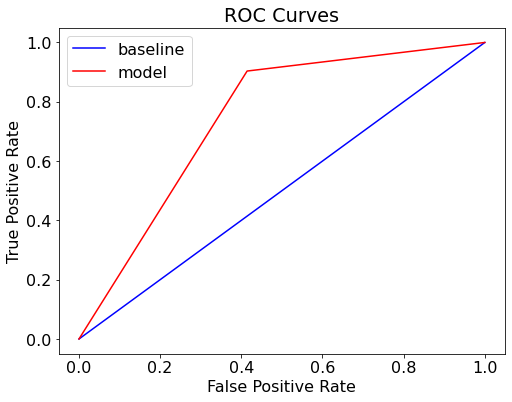

In [122]:
evaluate_model(predictions, probs, train_predictions, train_probs)

There we can see the problem with a single decision tree where the maximum depth is not limited: __severe overfitting to the training data__. 

Another method to inspect the performance of a classification model is by making a confusion matrix.

### Confusion Matrix

In [123]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #cm.astype('float') is 2x2 matrix
        #cm.sum(axis=1) is 1 row matrix
        #cm.sum(axis=1)[:, np.newaxis] is 1 column matrix
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    '''
    # itertools example
    https://www.geeksforgeeks.org/python-itertools-product/
    '''
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 3184  2252]
 [ 2361 22133]]


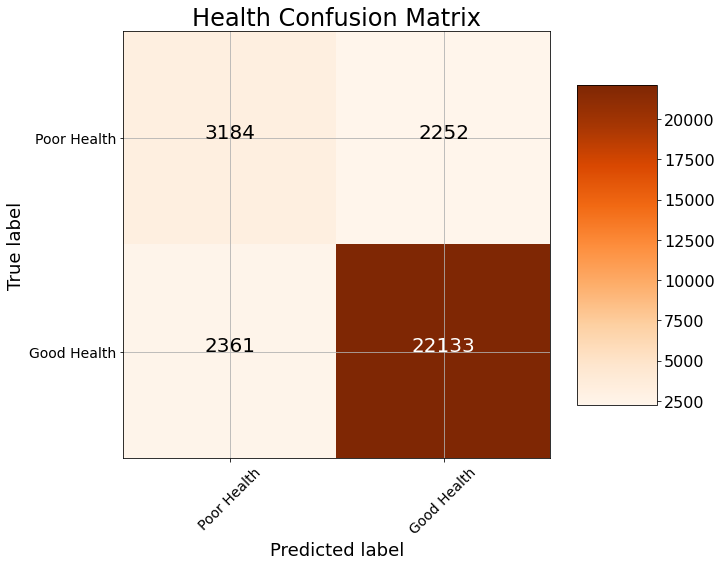

In [124]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, normalize=False,classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

This shows the classifications predicted by the model on the test data along with the real labels. We can see that our model has  false negatives (predicted good health but actually poor health) and  false positives (predicted poor health but actually good health). 

### Feature Importances

Finally, we can take a look at the features considered most important by the Decision Tree. The values are computed by summing the reduction in Gini Impurity over all of the nodes of the tree in which the feature is used. 

In [125]:
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).sort_values('importance', ascending = False)
fi.head()

feature  importance
25   EMPLOY1    0.139875
33   _LLCPWT    0.053289
28    _STSTR    0.042806
16  CHCCOPD1    0.037567
29    _STRWT    0.034660

We won't go through the definitions here, but you can look through the [data dictionary](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system#2015_formats.json) to determine the meaning of each feature. 

### Visualize Full Tree

As before, we can look at the decision tree on the data. This time, we have to limit the maximum depth otherwise the tree will be too large and cannot be converted and displayed as an image. 

In [126]:
# Save tree as dot file
export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

from subprocess import call
# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

from IPython.display import Image

# Visualize
Image(filename='tree_real_data.png')

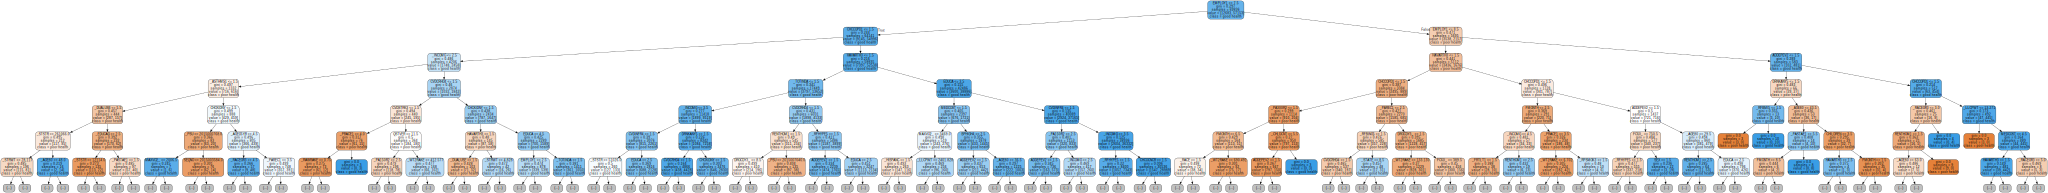

In [127]:
from graphviz import Source
Source.from_file("tree_real_data.dot")


We can see that our model is extremely deep and has many nodes. To reduce the variance of our model, we could limit the maximum depth or the number of leaf nodes. Another method to reduce the variance is to use more trees, each one trained on a random sampling of the observations. This is where the random forest comes into play. 

# Random Forest 

Now we can move on to a more powerful model, the random forest. This takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. Each tree is trained on a random set of the observations, and for each split of a node, only a subset of the features are used for making a split. When making predictions, the random forest averages the predictions for each of the individual decision trees for each data point in order to arrive at a final classification.

Creating and training a random forest in extremely easy in Scikit-Learn. The cell below is all you need.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [128]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=100,
                       verbose=1)

In [142]:
# attribute of randomforestclassifier model  is estimators_ . It contains different trees
print(type(model.estimators_))

<class 'list'>


In [151]:
# print trees in model
for ind_tree in model.estimators_:
    print(ind_tree)

DecisionTreeClassifier(max_features='sqrt', random_state=186422792)
DecisionTreeClassifier(max_features='sqrt', random_state=735107864)
DecisionTreeClassifier(max_features='sqrt', random_state=1195587395)
DecisionTreeClassifier(max_features='sqrt', random_state=1769725799)
DecisionTreeClassifier(max_features='sqrt', random_state=1823289175)
DecisionTreeClassifier(max_features='sqrt', random_state=113311823)
DecisionTreeClassifier(max_features='sqrt', random_state=1480802224)
DecisionTreeClassifier(max_features='sqrt', random_state=638252938)
DecisionTreeClassifier(max_features='sqrt', random_state=20267358)
DecisionTreeClassifier(max_features='sqrt', random_state=673068980)
DecisionTreeClassifier(max_features='sqrt', random_state=522135394)
DecisionTreeClassifier(max_features='sqrt', random_state=800870453)
DecisionTreeClassifier(max_features='sqrt', random_state=733361730)
DecisionTreeClassifier(max_features='sqrt', random_state=902405858)
DecisionTreeClassifier(max_features='sqrt', r

In [149]:
for ind_tree in model.estimators_:
    print(ind_tree.tree_)

In [148]:
#print nodes in each tree
for ind_tree in model.estimators_:
    print(ind_tree.tree_.node_count)

15527
15537
15391
15689
15447
15351
15475
15653
15221
15677
15315
15515
15903
15173
15579
15621
15487
15463
15335
15403
15637
15509
15763
15637
15461
15541
15699
15613
15325
15893
15673
15493
15755
15349
15391
15737
15599
15523
15657
15903
15571
15315
15269
15695
15747
15693
15525
15407
15461
15573
15135
15501
15447
15705
15543
15595
15569
15575
15663
15509
15149
15483
15693
15585
15547
15431
15747
15427
15667
15551
15565
15587
15417
15459
15507
15613
15537
15531
15407
15349
15565
15475
15719
15543
15423
15467
15371
15491
15397
15691
15943
15329
15423
15815
15299
15641
15461
15457
15469
15687


In [150]:
#print max depth of each tree
for ind_tree in model.estimators_:
    print(ind_tree.tree_.max_depth)

34
36
39
36
40
46
35
41
37
41
40
37
35
40
40
40
43
35
40
36
35
40
37
33
37
38
38
37
37
39
40
34
42
36
39
35
37
41
38
36
43
42
38
41
40
35
36
37
44
39
37
36
38
34
37
36
38
37
39
36
44
33
44
38
45
40
41
34
42
40
40
39
35
36
35
39
35
38
35
36
40
39
38
41
41
37
38
35
37
35
37
38
38
37
40
37
45
34
35
40


We can see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

In [129]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 15533
Average maximum depth 38


We see that each decision tree in the forest has many nodes and is extremely deep. However, even though each individual decision tree may overfit to a particular subset of the training data, the idea is that the overall random forest should have a reduced variance. 

## Random Forest Results

In [130]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished


Recall Baseline: 1.0 Test: 0.98 Train: 1.0
Precision Baseline: 0.82 Test: 0.9 Train: 1.0
Roc Baseline: 0.5 Test: 0.91 Train: 1.0


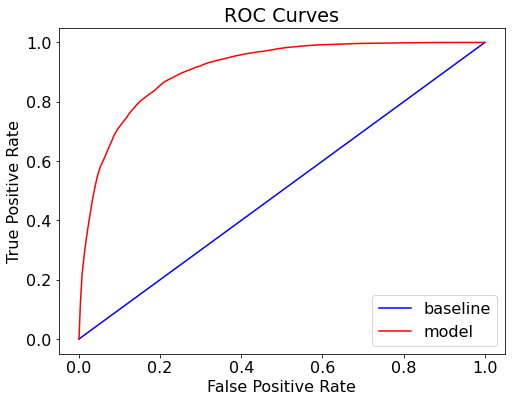

In [131]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The model still achieves perfect measures on the training data, but this time, the testing scores are much better. If we compare the ROC AUC, we see that the random forest does significantly better than a single decision tree. 

Confusion matrix, without normalization
[[ 2851  2585]
 [  612 23882]]


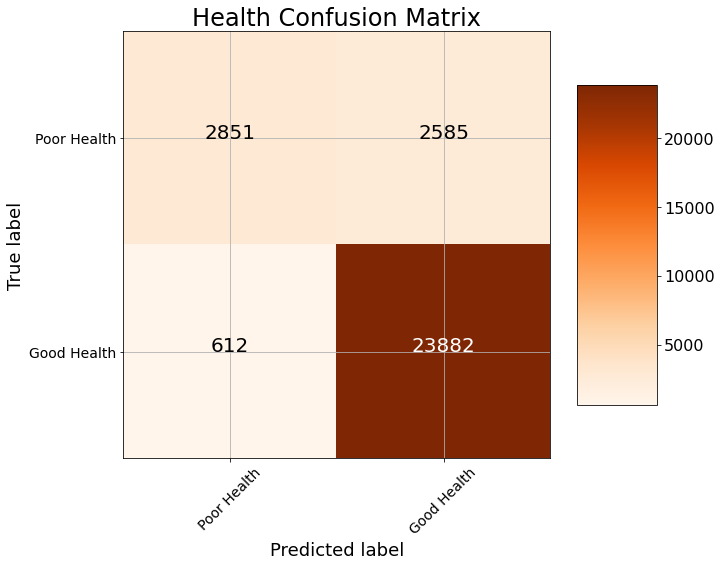

In [132]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

Compared to the single decision tree, the model has fewer false postives although more false negatives. __Overall, the random forest does significantly better than a single decision tree__. This is what we expected!

In [133]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

feature  importance
25   EMPLOY1    0.067216
33   _LLCPWT    0.036906
53   _INCOMG    0.034585
28    _STSTR    0.033366
31  _WT2RAKE    0.032909
72   MAXVO2_    0.031906
73     FC60_    0.031525
3      SEQNO    0.031405
4       _PSU    0.031333
29    _STRWT    0.031312

Our model does pretty well! Compared to the single decision tree, the random forest is much better able to generalize to new data.

# Random Forest Optimization through Random Search

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best. 


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [134]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(train, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=100),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 3, 4, 4, 4, 5,
                                                      5, 5, 6, 6, 6, 7, 7, 7, 8,
                                                      8, 8, 9, 9, 9, 10, 10, 10,
                                                      11, 11, 12, 12, 12, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10,
                                                           10, 10, 10, 10, 10,
                                    

In [135]:
rs.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': 46,
 'min_samples_split': 5,
 'n_estimators': 188}

We can see that the best hyperparameter values are not the defaults. This shows the importance of tuning a model for a specific dataset. Each dataset will have different characteristics, and the model that does best on one dataset will not necessarily do the best across all datasets. 

### Use Best Model

Now we can take the best model (it has already been trained) and evaluate it. Hopefully it does better than the stock Random Forest.

In [136]:
best_model = rs.best_estimator_

In [137]:
train_rf_predictions = best_model.predict(train)
train_rf_probs = best_model.predict_proba(train)[:, 1]

rf_predictions = best_model.predict(test)
rf_probs = best_model.predict_proba(test)[:, 1]

In [138]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 91
Average maximum depth 9


The best maximum depth is not unlimited as we see above! This indicates that restricting the maximum depth of the individual decision trees can improve the cross validation performance of the random forest. 

Recall Baseline: 1.0 Test: 0.99 Train: 0.99
Precision Baseline: 0.82 Test: 0.85 Train: 0.85
Roc Baseline: 0.5 Test: 0.85 Train: 0.85


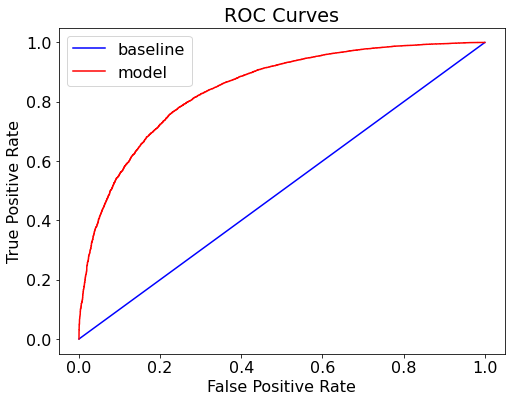

In [139]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

The optimized model achieves around the same performance as the default model. More random search iterations could improve performance, or it's possible that we are close the limit of what the random forest can achieve for this problem.

In [140]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

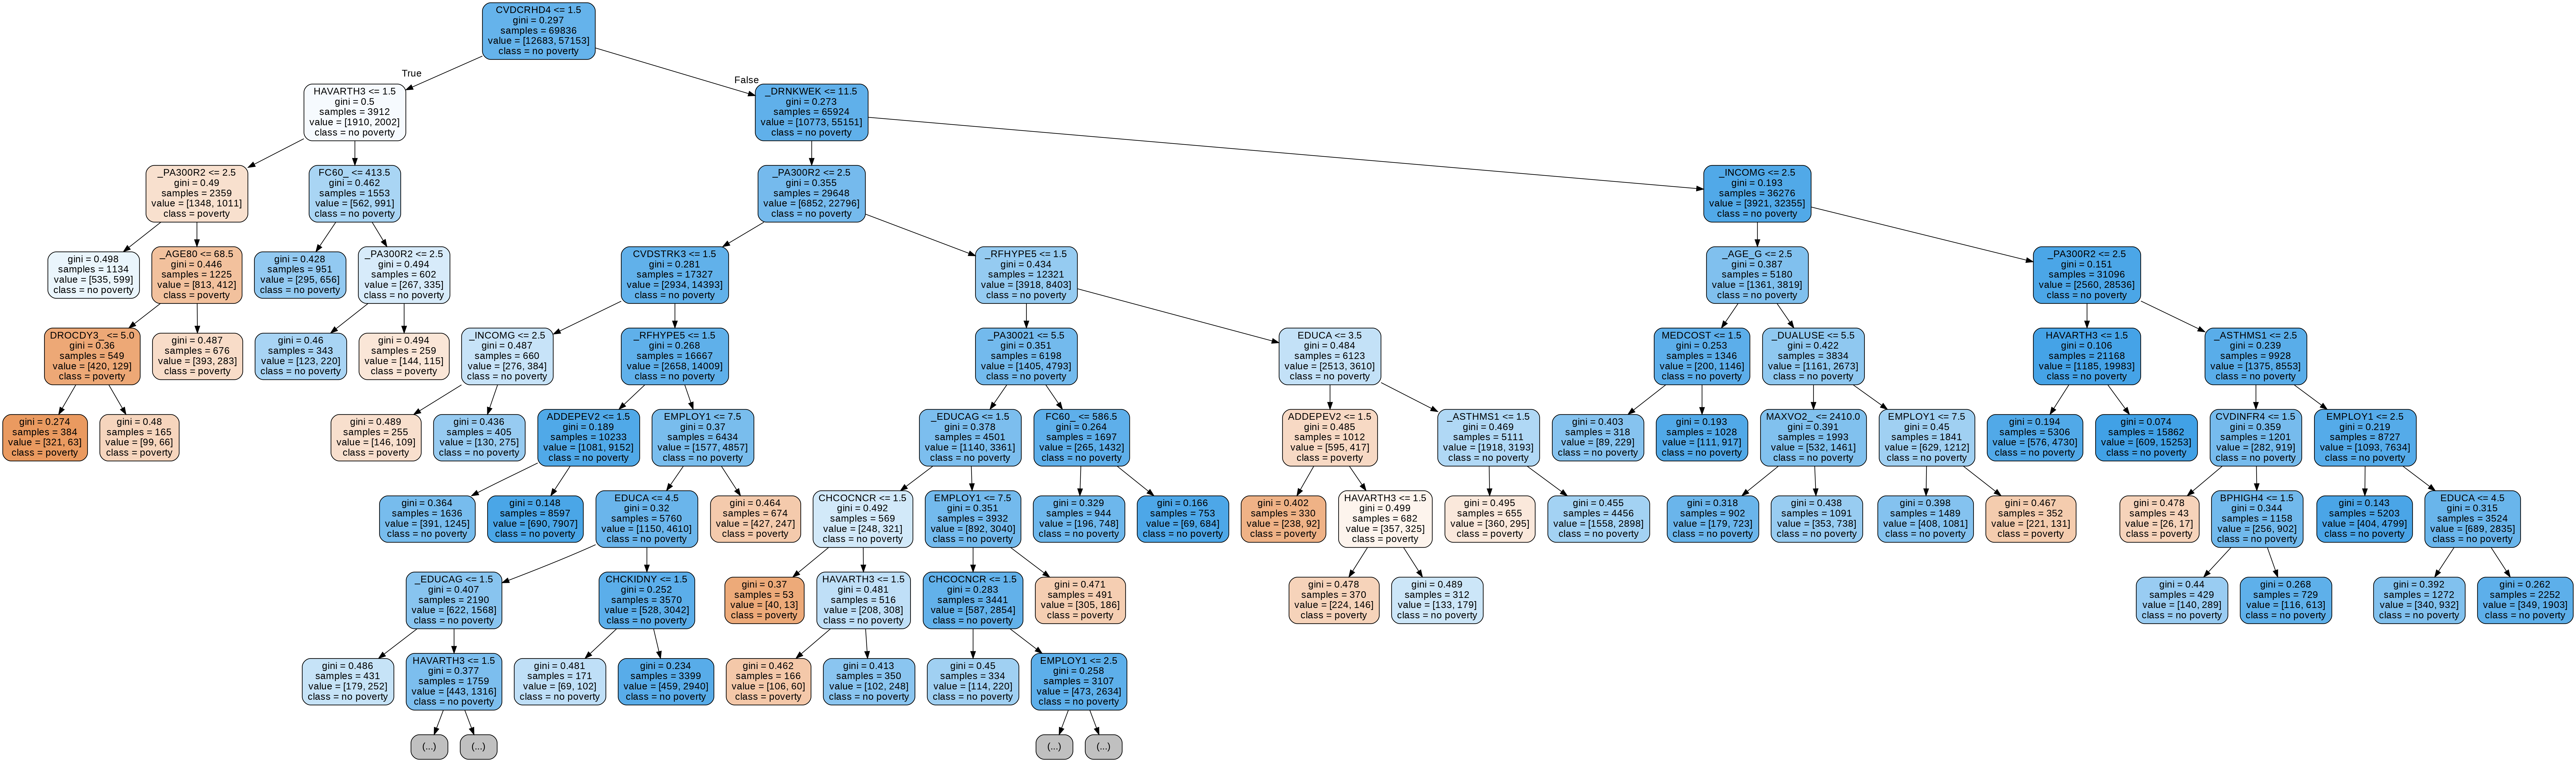

In [141]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

This tree is a little simpler than the solitary decision tree model. Random search found that limiting the maximum depth of the trees in the forest delivers better performance than letting them expand as far as needed. 

# Conclusions

In this notebook, we built and used a random forest machine learning model in Python. Rather than just writing the code and not understanding the model, we formed an understanding of the random forest by inspecting an individual decision tree and discussion its limitations. We visualized the decision tree to see how it makes decisions and also saw how one decision tree overfits to the trainig data. __To overcome the limitations of a single decision tree, we can train hundreds or thousands of them in a single ensemble model. This model, known as a random forest, trains each tree on a different set of the training observations, and make splits at each node based on a subset of the features leading to a model with reduced variance and better generalization performance on the testing set.__

A few key concepts to take away are

1. Individual decision tree: intuitive model that makes decisions based on a flowchart of questions asked about feature values. Has high variance indicated by overfitting to the training data.
2. Gini Impurity: Measure that the decision tree tries to minimize when splitting each node. Represents the probability that a randomly selected sample from a node will be incorreclty classified according to the distribution of samples in the node.
3. Bootstrapping: sampling random sets of observations with replacement. Method used by the random forest for training each decision tree.
4. Random subsets of features: selecting a random set of the features when considering how to split each node in a decision tree.
5. Random Forest: ensemble model made of hundreds or thousands of decision trees using bootstrapping, random subsets of features, and average voting to make predictions. 
6. Bias-variance tradeoff: the fundamental issue in machine learning that describes the tradeoff between a model with high complexity that learns the training data very well  at the cost of not being able to generalize to the testing data (high variance), and a simple model (high bias) that cannot even learn the training data. A random forest reduces the variance of a single decision tree while also accurately learning the training data leading to better predictions on the testing data.

Hopefully this notebook has given you not only the code required to use a random forest, but also the background necessary to understand how the model is making decisions. Machine learning is a powerful tool and it's important to not only know how to use the tool, but also to understand how it works!